# TensorFlow Speech Recognition Challenge

### Can you build an algorithm that understands simple speech commands?

From here : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [1]:
import os
import re
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

### Read data

In [3]:
def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label, label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    
    columns_list = ['label', 'label_id', 'user_id', 'wav_file']
    
    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    
    return train_df, valid_df

Combien d'exemples de test ?

In [4]:
train_df, valid_df = load_data('./data/')

There are 57929 train and 6798 val samples


In [5]:
train_df.head()

,label,label_id,user_id,wav_file
0,yes,0,708b8d51,./data/train/audio/yes/708b8d51_nohash_0.wav
1,yes,0,db79a764,./data/train/audio/yes/db79a764_nohash_0.wav
2,yes,0,c6a23ff5,./data/train/audio/yes/c6a23ff5_nohash_0.wav
3,yes,0,c93d5e22,./data/train/audio/yes/c93d5e22_nohash_2.wav
4,yes,0,b575b5fb,./data/train/audio/yes/b575b5fb_nohash_0.wav


In [6]:
train_df.label.value_counts()

unknown    36818
stop        2134
yes         2116
up          2115
go          2112
right       2111
on          2110
left        2106
no          2105
off         2101
down        2095
silence        6
Name: label, dtype: int64

In [7]:
silence_files = train_df[train_df.label == 'silence']
train_df      = train_df[train_df.label != 'silence']

In [8]:
from scipy.io import wavfile

In [9]:
def read_wav_file(fname):
    _, wav = wavfile.read(fname)
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
    return wav

In [10]:
silence_data = np.concatenate([read_wav_file(x) for x in silence_files.wav_file.values])

/usr/local/lib/python2.7/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


### Process audio files

In [11]:
from scipy.signal import stft

In [12]:
def process_wav_file(fname):
    wav = read_wav_file(fname)
    
    L = 16000  # 1 sec
    
    if len(wav) > L:
        i = np.random.randint(0, len(wav) - L)
        wav = wav[i:(i+L)]
    elif len(wav) < L:
        rem_len = L - len(wav)
        i = np.random.randint(0, len(silence_data) - rem_len)
        silence_part = silence_data[i:(i+L)]
        j = np.random.randint(0, rem_len)
        silence_part_left  = silence_part[0:j]
        silence_part_right = silence_part[j:rem_len]
        wav = np.concatenate([silence_part_left, wav, silence_part_right])
    
    specgram = stft(wav, 16000, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
    phase = np.angle(specgram[2]) / np.pi
    amp = np.log1p(np.abs(specgram[2]))
    
    return np.stack([phase, amp], axis = 2)

### Build keras model

In [28]:
# Weights file
model_file = './weights/model.hdf5'

In [29]:
import random
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.utils import to_categorical

In [30]:
def train_generator(train_batch_size):
    while True:
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(process_wav_file(this_train.wav_file.values[i]))
                y_batch.append(this_train.label_id.values[i])
            x_batch = np.array(x_batch)
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch


In [31]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(process_wav_file(valid_df.wav_file.values[i]))
                y_batch.append(valid_df.label_id.values[i])
            x_batch = np.array(x_batch)
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [32]:
def build_model():
    """ return keras model """
    x_in = Input(shape = (257,98,2))
    x = BatchNormalization()(x_in)
    for i in range(4):
        x = Conv2D(16*(2 ** i), (3,3))(x)
        x = Activation('elu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (1,1))(x)
    x_branch_1 = GlobalAveragePooling2D()(x)
    x_branch_2 = GlobalMaxPool2D()(x)
    x = concatenate([x_branch_1, x_branch_2])
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(len(POSSIBLE_LABELS), activation = 'softmax')(x)
    model = Model(inputs = x_in, outputs = x)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [33]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [34]:
model = build_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 257, 98, 2)    0                                            
____________________________________________________________________________________________________
batch_normalization_11 (BatchNor (None, 257, 98, 2)    8           input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_11 (Conv2D)               (None, 255, 96, 16)   304         batch_normalization_11[0][0]     
____________________________________________________________________________________________________
activation_9 (Activation)        (None, 255, 96, 16)   0           conv2d_11[0][0]                  
___________________________________________________________________________________________

### Load model weights

In [35]:
print('Loading model from {}'.format(model_file))
model.load_weights(model_file)

Loading model from ./weights/model.hdf5


### Train the model

In [36]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=0.01,
                           mode='min'),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                               mode='min'),
             ModelCheckpoint(monitor='val_loss',
                             filepath=model_file,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')]

In [37]:
# 12 epochs ont ete faite sur model.hdf5

model.fit_generator(generator=train_generator(64),
                              steps_per_epoch=344,
                              epochs=12,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=valid_generator(64),
                              validation_steps=int(np.ceil(valid_df.shape[0]/64)))

Epoch 1/12
344/344 [==============================] - 1469s - loss: 0.4033 - acc: 0.8753 - val_loss: 0.6896 - val_acc: 0.7763
Epoch 2/12
344/344 [==============================] - 1342s - loss: 0.3641 - acc: 0.8860 - val_loss: 0.4781 - val_acc: 0.8580
Epoch 3/12
344/344 [==============================] - 1356s - loss: 0.3431 - acc: 0.8929 - val_loss: 0.3973 - val_acc: 0.8754
Epoch 4/12
344/344 [==============================] - 1357s - loss: 0.3203 - acc: 0.9009 - val_loss: 0.7732 - val_acc: 0.7451
Epoch 5/12
344/344 [==============================] - 1358s - loss: 0.3164 - acc: 0.9011 - val_loss: 0.6407 - val_acc: 0.8049
Epoch 6/12
344/344 [==============================] - 1354s - loss: 0.2949 - acc: 0.9107 - val_loss: 0.6474 - val_acc: 0.8099
Epoch 7/12
343/344 [============================>.] - ETA: 3s - loss: 0.2808 - acc: 0.9153
Epoch 00006: reducing learning rate to 0.00010000000475.
344/344 [==============================] - 1368s - loss: 0.2813 - acc: 0.9152 - val_loss: 0.8691

### Test the model

6464/6464 [==============================] - 97s    

Report
             precision    recall  f1-score   support

          0       0.95      0.82      0.88       261
          1       0.35      0.97      0.51       270
          2       0.00      0.00      0.00         0
          3       0.57      0.89      0.69       264
          4       0.70      0.86      0.77       247
          5       0.46      0.90      0.61       256
          6       0.88      0.76      0.82       257
          7       0.76      0.78      0.77       256
          8       0.78      0.74      0.76       246
          9       0.74      0.47      0.57       260
         11       0.98      0.68      0.80      4147

avg / total       0.87      0.72      0.77      6464


Confusion matrix


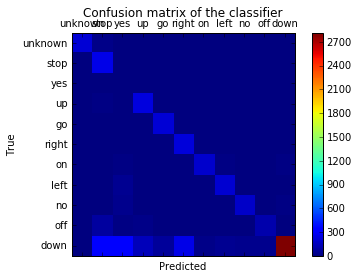

In [121]:
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import confusion_matrix, classification_report

def generator_to_subset(gen, size):
    """ Return a ndarray of size elements for generator gen (gen yields mini batches (X, y)) """
    X, Y = next(gen)
    for _ in range(size):
        x, y = next(gen)
        X = np.concatenate((X, x), axis=0)
        Y = np.concatenate((Y, y), axis=0)
    return X, Y

def plot_confusion_matrix(cm, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    
    # Force multi labels
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

test_set, test_labels = generator_to_subset(valid_generator(64), 100) # 6798 validation instances
test_labels = np.argmax(test_labels, axis=1)

# Predicting classes
y_pred = model.predict(test_set, batch_size=64, verbose=1)
#target_names = ['unknown', 'stop', 'yes', 'up', 'go', 'right', 'on', 'left', 'no', 'off', 'down', 'silence']
predicted_classes = np.argmax(y_pred, axis=1)
   
print("\nReport")
print(classification_report(test_labels, predicted_classes)) #, target_names=target_names, digits = 3))
      
print("\nConfusion matrix")    
cm = confusion_matrix(test_labels, predicted_classes)
plot_confusion_matrix(cm, target_names)
print("\n\n")

### Prepare Kaggle submission

In [133]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [134]:
def test_generator(test_batch_size):
    while True:
        for start in range(0, len(test_paths), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(test_paths))
            this_paths = test_paths[start:end]
            for x in this_paths:
                x_batch.append(process_wav_file(x))
            x_batch = np.array(x_batch)
            yield x_batch

In [135]:
predictions = model.predict_generator(test_generator(64), steps=int(np.ceil(len(test_paths)/64)))

In [136]:
classes = np.argmax(predictions, axis=1)

In [137]:
# last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [138]:
with open('submission.csv', 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))